# Explainability

1. Train at least two advanced models on the energy dataset
from TSA_Example notebook. You may choose to use only
the last 5 years of the dataset to reduce data size
2. Explain the patterns the model has learned using SHAP
local and global plots
3. Explain the patterns using LIME
4. Compare the answers from LIME & SHAP (global & some
local) – what do you see? Is it the same?


In [2]:
import os
import kagglehub
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping



c:\Users\Hassan\miniconda3\envs\tensorvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing

In [3]:
# Download latest version
kagglehub.dataset_download("robikscube/hourly-energy-consumption")
file_path = "C:\\Users\\Hassan\\.cache\\kagglehub\\datasets\\robikscube\\hourly-energy-consumption\\versions\\3\\PJME_hourly.csv"
data = pd.read_csv(file_path)
data['Datetime'] = pd.to_datetime(data['Datetime'])


end_date = data['Datetime'].max()
start_date = end_date - pd.DateOffset(years=5)

# filtering the data to include only the last 5 years
data = data[(data['Datetime'] >= start_date) & (data['Datetime'] <= end_date)]

In [4]:
# preprocessing code nabbed from mlflow_task.ipynb since we already did this there:
#dropping duplicates
data = data.drop_duplicates(subset="Datetime")

#setting DateTime as index, making sure its in datetime format and sorting after the index to get chronological data
data = data.set_index("Datetime")
data.index = pd.to_datetime(data.index)
data  = data.sort_index()

#to identify missing timestamps
#create a range of timestamps hourly frequency h as our data is
ts_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="h")
#differnce between the timestamp range and index of our dataframe will contain any missing time stamps
missing_timestamps = ts_range.difference(data.index)
missing_timestamps

#adding the range to df
data = data.reindex(ts_range)
data.loc["2005-04-03 00:00:02":"2005-04-03 05:00:00"]

#fill these by linear interpolation
data = data.interpolate(method='linear')
data.loc["2005-04-03 00:00:00":"2005-04-03 012:00:00"]

#adding the range to df
data = data.reindex(ts_range)
data.loc["2005-04-03 00:00:02":"2005-04-03 05:00:00"]

# extracting specific components from the datetime index
data["hour"] = data.index.hour
data["day"] = data.index.day
data["month"] = data.index.month
data["weekday"] = data.index.weekday


data

,PJME_MW,hour,day,month,weekday
2013-08-03 00:00:00,32081.0,0,3,8,5
2013-08-03 01:00:00,29409.0,1,3,8,5
2013-08-03 02:00:00,27455.0,2,3,8,5
2013-08-03 03:00:00,26207.0,3,3,8,5
2013-08-03 04:00:00,25442.0,4,3,8,5
...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,2,8,3
2018-08-02 21:00:00,43256.0,21,2,8,3
2018-08-02 22:00:00,41552.0,22,2,8,3
2018-08-02 23:00:00,38500.0,23,2,8,3


In [5]:
data

,PJME_MW,hour,day,month,weekday
2013-08-03 00:00:00,32081.0,0,3,8,5
2013-08-03 01:00:00,29409.0,1,3,8,5
2013-08-03 02:00:00,27455.0,2,3,8,5
2013-08-03 03:00:00,26207.0,3,3,8,5
2013-08-03 04:00:00,25442.0,4,3,8,5
...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,2,8,3
2018-08-02 21:00:00,43256.0,21,2,8,3
2018-08-02 22:00:00,41552.0,22,2,8,3
2018-08-02 23:00:00,38500.0,23,2,8,3


In [6]:
# prep feature and target
X = data.drop(columns=['PJME_MW'])
y = data['PJME_MW']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Linear regression models are considered simple - going with RF and NN models instead 
# #fitting linear model
# lin_reg = LinearRegression()
# lin_reg.fit(X_train, y_train)

# # coefficient print
# print("Coefficients:", lin_reg.coef_)
# print("Intercept:", lin_reg.intercept_)

# # Feature importance via correlation
# feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': lin_reg.coef_})
# feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# # Plot feature importance
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
# plt.title('Feature Importance (Linear Regression)')
# plt.show()

## 1. Train at least two advanced models on the energy dataset from TSA_Example notebook. You may choose to use only the last 5 years of the dataset to reduce data size

### RandomForestRegressor model

Trained our model on our preprocessed data - displays what we might have expected. Hour has the most to impact on the target. Followed by month, and day.<br>
We display this by dataframe, as a barplot plotting the importance. We also display the change in usage of energy over day, month and year. The latter is good to get an idea of the patters we observe in the timeseries data 

In [7]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance for our complex model
importances = rf.feature_importances_
feature_importance_rf = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
feature_importance_rf


,Feature,Importance
0,hour,0.365851
2,month,0.297314
1,day,0.202350
3,weekday,0.134484


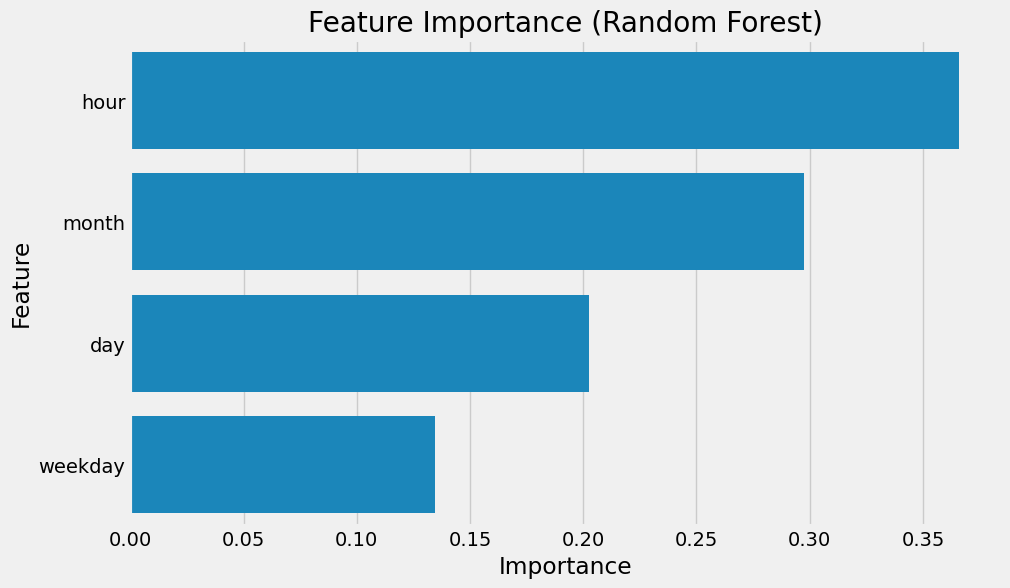

In [8]:
#plotting the importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf)
plt.title('Feature Importance (Random Forest)')
plt.show()


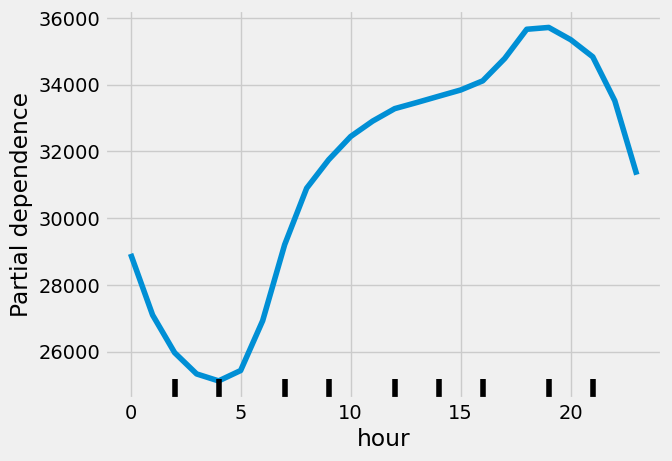

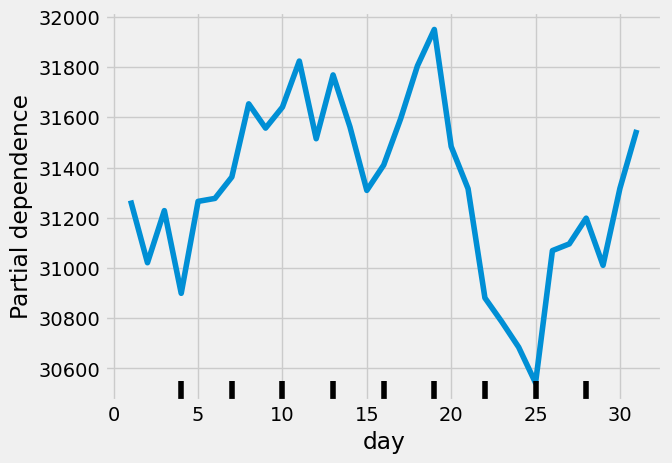

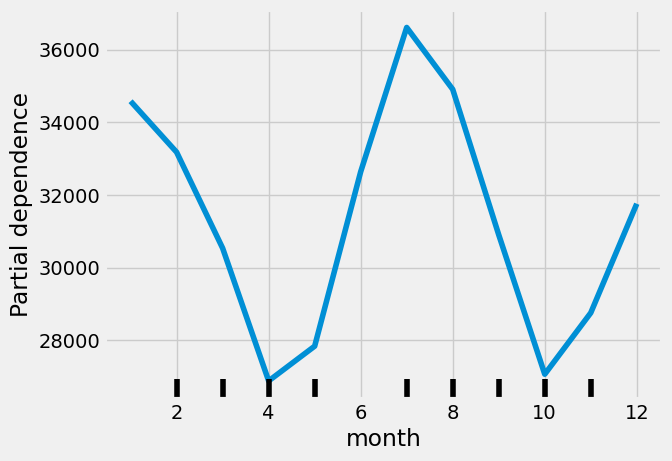

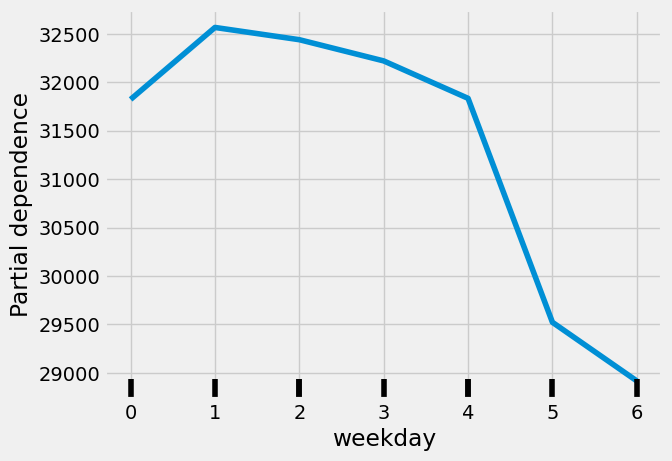

In [9]:
# Partial Dependence plot for all features
for i in range(len(feature_importance_rf)):  
    PartialDependenceDisplay.from_estimator(rf, X_train, [i])
    plt.show()

### Neural Network Sequential model

We start out with scaling our data using standard scaler. Hopefully we dont have too many outliers as StandardScalar is sensitive to outliers. <br>
After this we define our model, sequential two dense layers with 64 and 32 units. both with relu as activation. Finally a single dense output layer with a single unit. No activation functions because this is a regression task (predicting conti. values).

We use the adam optimizer. Its a popular one, works well for many problems.
MSE as loss function - suitable for regression tasks -penalizing larger errors rather than smaller errors.
Metrics: accuracy, precision, f1-score and recall are used for classification tasks, where as MAE, MSE, RMSE, R² are typically used for regression tasks.
(source: https://keras.io/api/metrics/)

we use early stopping - and validate on our scaled data.


In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
model = keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output layer
])

model.compile(optimizer="adam",
              loss="mean_squared_error",
              metrics=['mean_absolute_error', 'mean_squared_error'])

#we will pull out early if there validation loss doesnt improve after 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

partial_history = model.fit(X_train,
                    y_train,
                    epochs = 50,
                    batch_size=16,
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[early_stopping])

Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 513155680.0000 - mean_absolute_error: 19126.1270 - mean_squared_error: 513155680.0000 - val_loss: 915609024.0000 - val_mean_absolute_error: 29581.0352 - val_mean_squared_error: 915609024.0000
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 88614896.0000 - mean_absolute_error: 7529.7622 - mean_squared_error: 88614896.0000 - val_loss: 825513024.0000 - val_mean_absolute_error: 27999.0137 - val_mean_squared_error: 825513024.0000
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 80620968.0000 - mean_absolute_error: 7137.6792 - mean_squared_error: 80620968.0000 - val_loss: 695043392.0000 - val_mean_absolute_error: 25568.9688 - val_mean_squared_error: 695043392.0000
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 68999264.0000 - mean_absolute_error: 6595.4761 - mean_squared_error: 68999264.0000 - val_loss: 498869824.0000 - val_mean_absolute_error: 21422.8047 - val_mean_squared_error: 49886982

## 2. Explain the patterns the model has learned using SHAP local and global plots

### Shap summary model intepretation:

Contrary to the random forest feature importance plot, the SHAP summary model shows the `weekday` to be of the most importance here. (SHAP helps identify important features based on impact to model output vs. RF Feature importance ranks based on models metrics)

#### Global patterns 
For the SHAP summary model, importance is ranked on the left side. The most important feature is at the top, and the others are in decreasing order of importance. The further the value is from 0 on the x-axis, the more it impacts the prediction.

* `weekday`: <br>
Our top feature on the left has the largest impact, as seen by the spread in weekdays' SHAP values being wide. As we saw in the Partial Dependence plots for Random Forest, weekday values are 0-6. 
According to pandas.Series.dt.weekday, "Weekdays values are 0-6 (Monday-Sunday)". <br>
If the value for `weekday` is high (i.e., weekend), its corresponding SHAP values are high. This means the most energy is used over the weekend.
If the value for `weekday` is low (Monday-Tuesday), the SHAP values go into the negatives. This means the lowest amount of energy is used at the start of the week.
So, `weekday` plays a big role in electricity demand.

* Hour: <br>
"The hours of the datetime.", according to pandas.Series.dt.hour
The second most impactful feature.
Low values for Hour (i.e., midnight to early morning) = negative SHAP values. This makes sense as lower energy consumption is normally seen when most people are sleeping.
Values around 12-22 => positive SHAP value.

* Month: <br>
"The month as January=1, December=12," according to pandas.Series.dt.month.
As I understand the graph, there is way more variation over the months. It seems like peaks in January, May, and August, as well as a steady rise in November and December.

* Day:<br>
"The day of the month 0-31," according to pandas.Series.dt.day.
Of course, because there is very little reason for people to use more or less electricity based on the date of the month (yet people do in this economy).
It does have some variance, but not enough to have a strong predictive influence.

### Explain the patterns using LIME

#### Local pattern
This waterfall plot—a type of LIME (local interpretable model-agnostic explanation) plot—displays to what degree my features have influenced the model's prediction for each single data point for the target. 
That means it is an individual prediction for a single target.


- Predicted output: f(x) = displays the predicted target for the instance depicted.
- Base value: E[f(X)] = expected average prediction without any features.
- The gray text before the feature names (don't know what it is called) shows the value of each feature for this sample.
- Red/blue: Positive/negative = displays the contribution of each feature in terms of moving the f(x) value.

In this instance, we see weekday having the biggest positive impact, followed by hour also having a positive impact. 
Month had a lower impact (negative), while day has the lowest impact also negative.


## Compare the answers from LIME & SHAP (global & some local) – what do you see? Is it the same?

We see the same trends mostly in both plots, with some alterations. 
Note that weekdays postiive impact in the waterfall plot is due to it being a negative value in this perturbation( -1,5). If it was +1,5, we would see that it would have had the biggest negative impact, just how it was seen in the SHAP summary model.

Weekday and hour are the biggest contributers to the target in both models.
Month and day supply with substantially lower negative effects.




ExactExplainer explainer: 8766it [01:05, 133.27it/s]                          


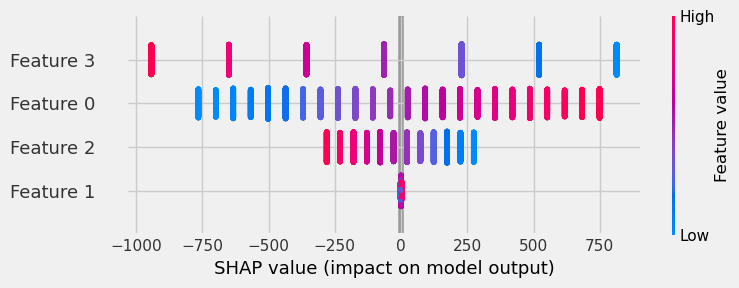

In [ ]:
##The code in this cell is taken directly from "xai-dl.ipynb"
# I was able to run it, but it gave little insight into the features weights. very difficult to see much distribution in the data without going pixelhunting.

# SHAP explainer for Neural Network
explainer_nn = shap.Explainer(model, X_train_scaled)
shap_values_nn = explainer_nn(X_test_scaled)

# SHAP summary plot for Neural Network
shap.summary_plot(shap_values_nn, X_test_scaled)

## I was breifly able to run the code below after having installed shap through pip (where both tensorflow and keras is installed through too), but this cause my environment to be unable to run code from tensorflow and keras.
# I tried creating new virtual environments, installing the required packages with both pip and conda, and a mix of versions of python too. No dice. 
#shap.force_plot(explainer_nn.expected_value, shap_values_nn[0].values, X_test_scaled[0], matplotlib=True)

ExactExplainer explainer: 8766it [00:47, 146.42it/s]                          


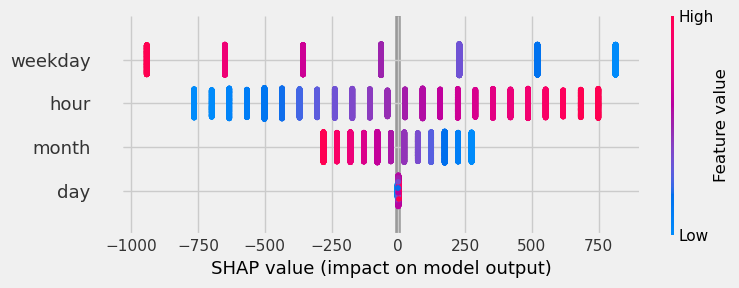

In [13]:
# tried to implement my own version of the above. Not much better.

#feature_map will iterate over the X.column names
feature_map = {i: name for i, name in enumerate(X.columns)}

# basic shap.Explainer for Neural Network
explainer_nn = shap.Explainer(model, X_train_scaled)
shap_values_nn = explainer_nn(X_test_scaled)

# SHAP summary plot for our model - displaying our feature names
shap.summary_plot(shap_values_nn, X_test_scaled, feature_names=feature_map)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


  2%|▏         | 1/50 [00:00<00:08,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  4%|▍         | 2/50 [00:00<00:08,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  6%|▌         | 3/50 [00:00<00:08,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


  8%|▊         | 4/50 [00:00<00:08,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


 10%|█         | 5/50 [00:00<00:08,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


 12%|█▏        | 6/50 [00:01<00:07,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 14%|█▍        | 7/50 [00:01<00:07,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step


 16%|█▌        | 8/50 [00:01<00:07,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 18%|█▊        | 9/50 [00:01<00:07,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 20%|██        | 10/50 [00:01<00:07,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 22%|██▏       | 11/50 [00:01<00:06,  5.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step


 24%|██▍       | 12/50 [00:02<00:06,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


 26%|██▌       | 13/50 [00:02<00:06,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 28%|██▊       | 14/50 [00:02<00:06,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step


 30%|███       | 15/50 [00:02<00:06,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 32%|███▏      | 16/50 [00:02<00:05,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


 34%|███▍      | 17/50 [00:02<00:05,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 36%|███▌      | 18/50 [00:03<00:05,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


 38%|███▊      | 19/50 [00:03<00:05,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 40%|████      | 20/50 [00:03<00:05,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 42%|████▏     | 21/50 [00:03<00:04,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 44%|████▍     | 22/50 [00:03<00:04,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 46%|████▌     | 23/50 [00:03<00:04,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


 48%|████▊     | 24/50 [00:04<00:04,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 50%|█████     | 25/50 [00:04<00:04,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 52%|█████▏    | 26/50 [00:04<00:03,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 54%|█████▍    | 27/50 [00:04<00:03,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 56%|█████▌    | 28/50 [00:04<00:03,  5.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 58%|█████▊    | 29/50 [00:04<00:03,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 60%|██████    | 30/50 [00:05<00:03,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 62%|██████▏   | 31/50 [00:05<00:03,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


 64%|██████▍   | 32/50 [00:05<00:02,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


 66%|██████▌   | 33/50 [00:05<00:02,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 68%|██████▊   | 34/50 [00:05<00:02,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 70%|███████   | 35/50 [00:05<00:02,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


 72%|███████▏  | 36/50 [00:06<00:02,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 74%|███████▍  | 37/50 [00:06<00:02,  5.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 76%|███████▌  | 38/50 [00:06<00:01,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 78%|███████▊  | 39/50 [00:06<00:01,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 80%|████████  | 40/50 [00:06<00:01,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 82%|████████▏ | 41/50 [00:06<00:01,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 84%|████████▍ | 42/50 [00:07<00:01,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 86%|████████▌ | 43/50 [00:07<00:01,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step


 88%|████████▊ | 44/50 [00:07<00:00,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step


 90%|█████████ | 45/50 [00:07<00:00,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


 92%|█████████▏| 46/50 [00:07<00:00,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 94%|█████████▍| 47/50 [00:08<00:00,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 96%|█████████▌| 48/50 [00:08<00:00,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step


 98%|█████████▊| 49/50 [00:08<00:00,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


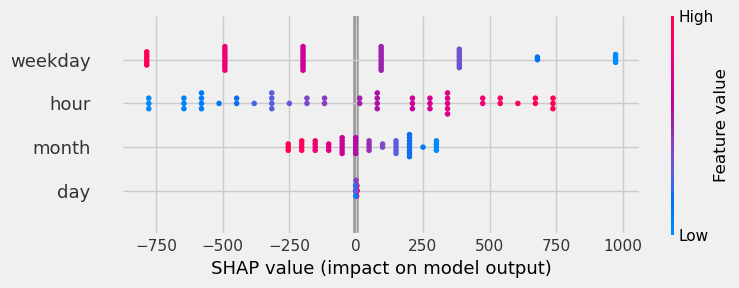

In [ ]:
#tried again using another explainer - kernelExplainer (https://shap.readthedocs.io/en/latest/generated/shap.KernelExplainer.html)

# extracting a randomly selected subset of our scaled training data - background is essentially training data for the SHAP value -  using this one 
background_samples = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

#a slower, model-agnostic explainer - takes our trained models predicuion func and back_samples
explainer = shap.KernelExplainer(model.predict, background_samples)

#Taking the first 50 samples from the scaled test data, using this as input for the KernelExplainer to generate shap_vals.
shap_values = explainer.shap_values(X_test_scaled[:50])  # Use a smaller subset for SPEED
#reshaped to numpy array, and matching the test data. 
shap_values = np.array(shap_values).reshape(-1, X_test_scaled.shape[1])
#plotting, using feature column names
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns)

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step


Using 35060 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


  2%|▏         | 1/50 [00:11<09:09, 11.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 492us/step


  4%|▍         | 2/50 [00:22<08:55, 11.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 493us/step


  6%|▌         | 3/50 [00:33<08:44, 11.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


  8%|▊         | 4/50 [00:44<08:31, 11.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 7s 485us/step


 10%|█         | 5/50 [00:55<08:17, 11.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 7s 485us/step


 12%|█▏        | 6/50 [01:06<08:04, 11.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 7s 483us/step


 14%|█▍        | 7/50 [01:17<07:52, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 7s 482us/step


 16%|█▌        | 8/50 [01:28<07:40, 10.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 496us/step


 18%|█▊        | 9/50 [01:39<07:32, 11.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 543us/step


 20%|██        | 10/50 [01:51<07:32, 11.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 521us/step


 22%|██▏       | 11/50 [02:02<07:24, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 509us/step


 24%|██▍       | 12/50 [02:14<07:12, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 504us/step


 26%|██▌       | 13/50 [02:25<07:00, 11.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 498us/step


 28%|██▊       | 14/50 [02:36<06:48, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


 30%|███       | 15/50 [02:48<06:36, 11.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 512us/step


 32%|███▏      | 16/50 [02:59<06:26, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 515us/step


 34%|███▍      | 17/50 [03:11<06:16, 11.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 507us/step


 36%|███▌      | 18/50 [03:22<06:05, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 515us/step


 38%|███▊      | 19/50 [03:34<05:56, 11.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 510us/step


 40%|████      | 20/50 [03:46<05:49, 11.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 496us/step


 42%|████▏     | 21/50 [03:57<05:35, 11.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 504us/step


 44%|████▍     | 22/50 [04:09<05:21, 11.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 515us/step


 46%|████▌     | 23/50 [04:20<05:09, 11.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 500us/step


 48%|████▊     | 24/50 [04:31<04:56, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 505us/step


 50%|█████     | 25/50 [04:43<04:44, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 507us/step


 52%|█████▏    | 26/50 [04:54<04:33, 11.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 500us/step


 54%|█████▍    | 27/50 [05:05<04:21, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 517us/step


 56%|█████▌    | 28/50 [05:17<04:11, 11.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 504us/step


 58%|█████▊    | 29/50 [05:28<03:59, 11.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 488us/step


 60%|██████    | 30/50 [05:40<03:47, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


 62%|██████▏   | 31/50 [05:51<03:34, 11.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 491us/step


 64%|██████▍   | 32/50 [06:02<03:22, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


 66%|██████▌   | 33/50 [06:13<03:10, 11.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 494us/step


 68%|██████▊   | 34/50 [06:24<02:59, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 11s 691us/step


 70%|███████   | 35/50 [06:39<03:04, 12.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 525us/step


 72%|███████▏  | 36/50 [06:51<02:49, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 513us/step


 74%|███████▍  | 37/50 [07:02<02:34, 11.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 493us/step


 76%|███████▌  | 38/50 [07:13<02:19, 11.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 518us/step


 78%|███████▊  | 39/50 [07:25<02:07, 11.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 494us/step


 80%|████████  | 40/50 [07:36<01:55, 11.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 490us/step


 82%|████████▏ | 41/50 [07:47<01:42, 11.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 510us/step


 84%|████████▍ | 42/50 [07:59<01:31, 11.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 495us/step


 86%|████████▌ | 43/50 [08:10<01:19, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 502us/step


 88%|████████▊ | 44/50 [08:21<01:08, 11.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 518us/step


 90%|█████████ | 45/50 [08:33<00:57, 11.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 509us/step


 92%|█████████▏| 46/50 [08:44<00:45, 11.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 500us/step


 94%|█████████▍| 47/50 [08:55<00:34, 11.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 507us/step


 96%|█████████▌| 48/50 [09:07<00:22, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 7s 486us/step


 98%|█████████▊| 49/50 [09:18<00:11, 11.24s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 503us/step


100%|██████████| 50/50 [09:29<00:00, 11.40s/it]


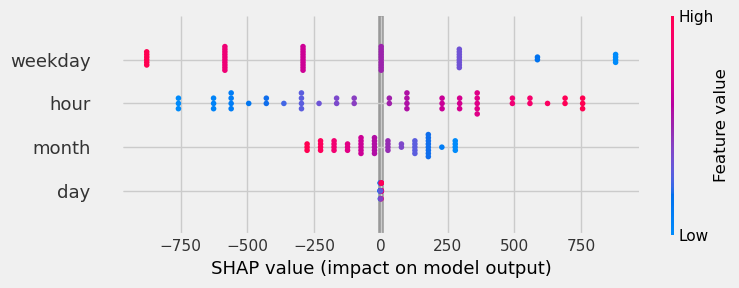

In [42]:
#same KernelExplainer without background_samples and just using X_train_scaled (took way too long)

explainer = shap.KernelExplainer(model.predict, X_train_scaled)

shap_values = explainer.shap_values(X_test_scaled[:50])  # Use a smaller subset for SPEED
shap_values = np.array(shap_values).reshape(-1, X_test_scaled.shape[1])
shap.summary_plot(shap_values, X_test_scaled[:50], feature_names=X.columns)


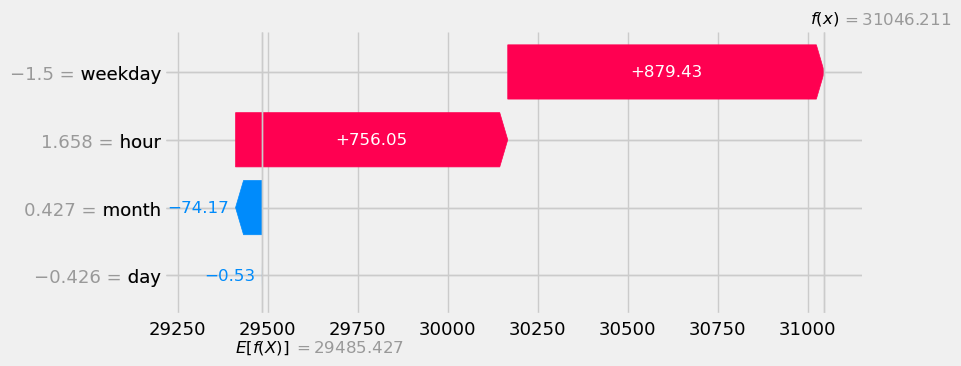

In [ ]:
#since I was unable to make the force_plot, I decided to make another type of LIME (local interpretable model-agnostic explanation) plot.
shap.waterfall_plot(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test_scaled[0], feature_names=X.columns))

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
15339/15339 ━━━━━━━━━━━━━━━━━━━━ 8s 515us/step


100%|██████████| 1/1 [00:11<00:00, 11.54s/it]


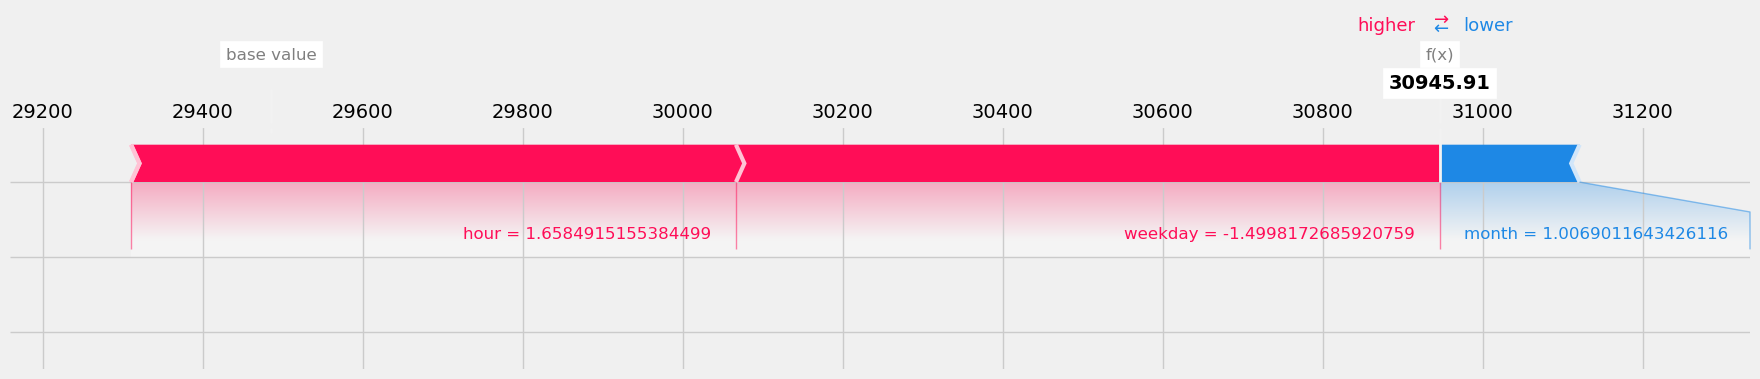

In [ ]:
# I managed to get it to work!!


# Select a single (specific) instance from X_test_scaled
instance_idx = 13  # Choosing any index, we choose 13
instance = X_test_scaled[instance_idx:instance_idx+1] 

 # computes the SHAP values for the instance selected (instance_idx) for the particular object
shap_values_instance = explainer.shap_values(instance) 
# reshaping and converting SHAP values in the same way as we did w. kernelExplainer cell
shap_values_instance = np.array(shap_values_instance).reshape(-1, instance.shape[1])

#plotting
shap.force_plot(explainer.expected_value, shap_values_instance, instance, matplotlib=True, feature_names=X.columns)


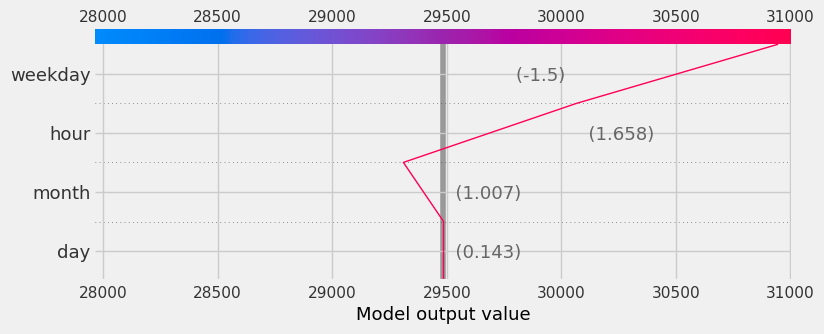

In [ ]:
# decision plot visualizes the decision making process of a model 
shap.decision_plot(explainer.expected_value, shap_values_instance, instance, feature_names=X.columns.to_list())
